In [3]:
# Import libraries
import os

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F 

import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, utils

import matplotlib.pyplot as plt # for plotting

import datetime
from tqdm import tqdm 

import cv2
from cv2 import cvtColor, COLOR_BGR2RGB, COLOR_LAB2RGB

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Loading in data


In [7]:
images_gray = np.load('./drive/MyDrive/kaggleDataset/l/gray_scale.npy')
# images_ab = np.load('./drive/MyDrive/COS429 Final Project/kaggleDataset/ab/ab/ab1.npy')
images_ab = np.concatenate([np.load('./drive/MyDrive/kaggleDataset/ab/ab/ab1.npy'),
                            np.load('./drive/MyDrive/kaggleDataset/ab/ab/ab2.npy'),
                            np.load('./drive/MyDrive/kaggleDataset/ab/ab/ab3.npy')],axis=0)

# Preprocess the data

In [8]:
full_dataset = []
for i in range(0, 25000):
  gray_dup = np.copy(images_gray[i])
  inp = torch.Tensor(gray_dup.reshape(1,224,224) / 255.0)
  out = torch.Tensor(images_ab[i] / 255.0)

  full_dataset.append([inp, torch.permute(out, (2, 0, 1))])

In [6]:
print(full_dataset[0][0].shape)
print(full_dataset[0][1].shape)

torch.Size([1, 224, 224])
torch.Size([2, 224, 224])


In [7]:
# split into batches
bch_size = 32 # train batch size
val_bch_size = 10 

train_size = 20000
val_size = 5000

In [8]:
train_data = full_dataset[:train_size] 

val_data = full_dataset[train_size:(train_size + val_size + 1)] 

In [9]:
train_loader = torch.utils.data.DataLoader(full_dataset, 
                                           batch_size=bch_size, 
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, 
                                         batch_size=val_bch_size, 
                                         shuffle=True)

# The Model

In [9]:
class Color(nn.Module):
    def __init__(self):
        super(Color, self).__init__()
        self.network = nn.Sequential(
          nn.Conv2d(1, 32, 3),
          nn.MaxPool2d(2, 2),
          # nn.BatchNorm2d(64),

          nn.Conv2d(32, 64, 3),
          nn.MaxPool2d(2, 2),
          
          nn.Conv2d(64, 128, 3),
          nn.MaxPool2d(2, 2),
          # nn.BatchNorm2d(128),
          
          nn.Conv2d(128, 256, 3),
          nn.MaxPool2d(2, 2),
          # nn.Upsample(scale_factor=2),
          # nn.BatchNorm2d(256),

          nn.Conv2d(256, 512, 3),
          nn.MaxPool2d(2, 2),
          nn.Upsample(scale_factor=2),
          nn.BatchNorm2d(512),

          nn.Conv2d(512, 256, 3),
          nn.MaxPool2d(2, 2),
          nn.Upsample(scale_factor=2),
          nn.BatchNorm2d(256),

          nn.Conv2d(256, 128, 3),
          nn.Upsample(scale_factor=2),
          nn.BatchNorm2d(128),

          nn.Conv2d(128, 64, 3),
          nn.Upsample(scale_factor=2),
          nn.BatchNorm2d(64),

          nn.Conv2d(64, 32, 3),

          nn.Conv2d(32, 2, 3)
          # nn.Upsample(scale_factor=2)
        )
        
    def forward(self, x):
        x = self.network(x)
        x = F.interpolate(x, (224,224))

        return x

In [10]:
torch.manual_seed(2023)

model = Color()
print(model)

Color(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Upsample(scale_factor=2.0, mode='nearest')
    (11): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1))
    (13): MaxPool2d(kernel_size=2, stride=2

In [13]:
def get_output_shape(model, image_dim):
    return model(torch.rand(*(image_dim))).data.shape

print(get_output_shape(model, (0,1,224,224))) # sanity check from https://stackoverflow.com/a/62197038

torch.Size([0, 2, 224, 224])


# Train the Model

In [21]:
def train(model, criterion, train_loader, val_loader, avg_val_loss, train_losses, num_epoch, 
          lr, bsize, start_epoch = 0):

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0)
    
    for epoch in range(start_epoch, start_epoch + num_epoch):
        model = model.to(device)
        model.train()

        with tqdm(train_loader, desc=f"Training Epoch {epoch}") as t:
            trainLoss = []   
            for batch_idx, (inputs, labels) in enumerate(t):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                t.set_postfix({'training_loss': loss.item()}) 

                trainLoss.append(loss.item())
                                           
            train_losses.append(np.mean(trainLoss))

        val_loss, correct = 0.0, 0
        model.eval() # sets the mode for validation
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Validating"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()

        avg_val_loss.append(val_loss / len(val_loader))

    return avg_val_loss, train_losses

In [22]:
random_seed = 2023
torch.manual_seed(random_seed)

lr = 0.0001
criterion = nn.MSELoss()

In [23]:
# 100 epochs to see any real results!
num_epoch = 10
avg_val_loss, train_losses = train(model, criterion, train_loader, val_loader, [], [], num_epoch, lr = lr, bsize = bch_size, start_epoch = 0)

Validating: 100%|██████████| 500/500 [00:04<00:00, 118.76it/s]


In [24]:
# PATH = "100epoch_512Features_SGD.pth"
# torch.save(model.state_dict(), PATH)

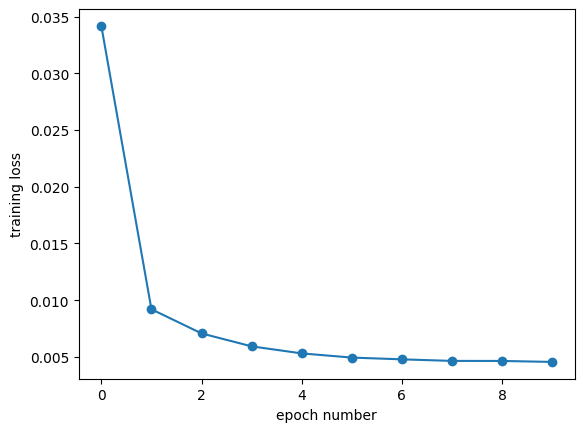

In [25]:
plt.ylabel('training loss')
plt.xlabel('epoch number')
plt.plot(train_losses, linestyle='-', marker='o')

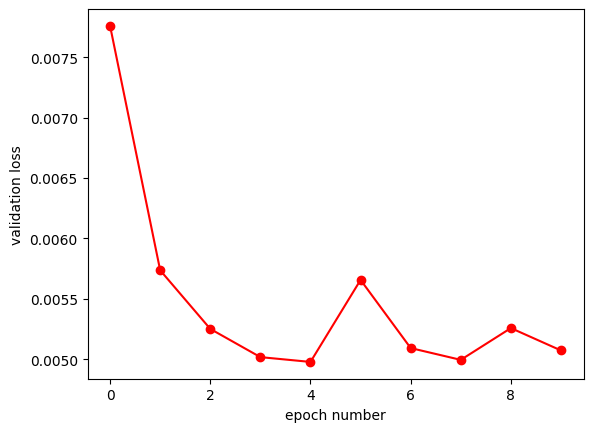

In [26]:
plt.ylabel('validation loss')
plt.xlabel('epoch number')
plt.plot(avg_val_loss, linestyle='-', marker='o', color='red')

# Results


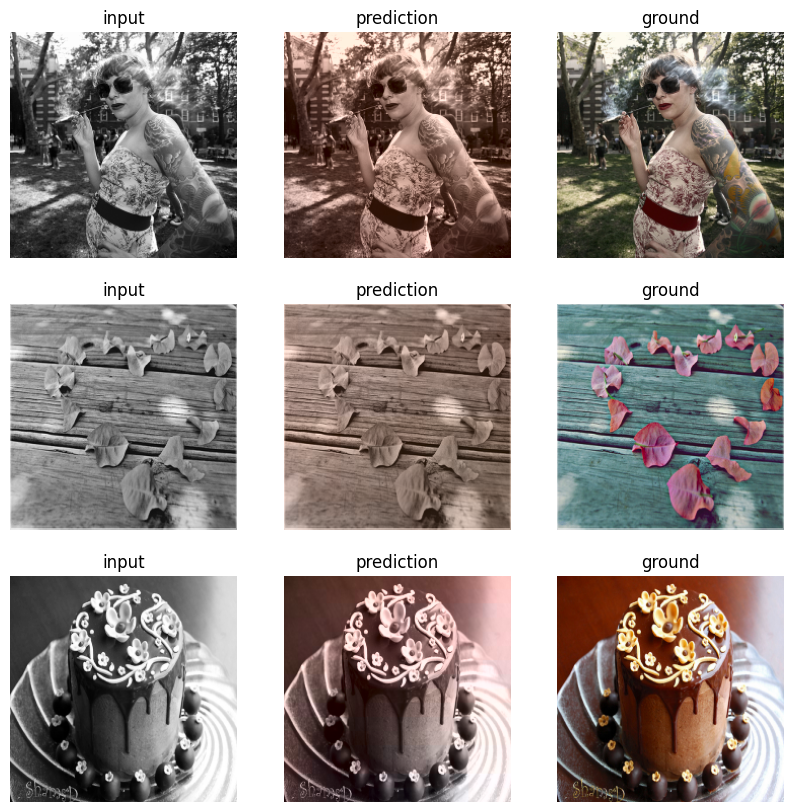

In [27]:
model = model.to(torch.device('cpu'))
predicts = []
for i in range(5):
  x = full_dataset[i][0][None]
  prediction = model(x).squeeze(0)
  predicts.append(prediction)

f, axarr = plt.subplots(3, 3)
f.set_size_inches(10, 10)

j = 0
for i in range(0, 3):
  color_image = torch.cat((full_dataset[i][0], predicts[j]), 0).detach().numpy() # combine channels
  color_image = color_image.transpose((1, 2, 0))
  color_image[:, :, 0:1] = color_image[:, :, 0:1] * 100
  color_image[:, :, 1:3] = color_image[:, :, 1:3] * 255 - 128   
  color_image = cv2.cvtColor(color_image, cv2.COLOR_LAB2RGB)

  ground = torch.cat((full_dataset[i][0], full_dataset[i][1]), 0).numpy() # combine channels
  ground = ground.transpose((1, 2, 0))
  ground[:, :, 0:1] = ground[:, :, 0:1] * 100
  ground[:, :, 1:3] = ground[:, :, 1:3] * 255 - 128   
  ground = cv2.cvtColor(ground, cv2.COLOR_LAB2RGB)

  axarr[j][0].imshow(full_dataset[i][0].squeeze().numpy(), cmap='gray')
  axarr[j][1].imshow(color_image)
  axarr[j][2].imshow(ground)
  axarr[j][0].axis('off'), axarr[j][1].axis('off'), axarr[j][2].axis('off')#, axarr[j][3].axis('off')
  axarr[j][0].set_title('input'), axarr[j][1].set_title('prediction'), axarr[j][2].set_title('ground')
  j += 1
plt.show()

In [17]:
# PATH = "100epoch_512Features.pth"
# model = Color()
# model.load_state_dict(torch.load(PATH))
# model.eval()

In [1]:
# from IPython.display import Image
# from torchviz import make_dot
# x = torch.rand(*(0,1,224,224))
# # y = model()
# out = model.forward(x)
# dot = make_dot(out, params=dict(model.named_parameters()))
# dot.format = 'png'
# dot.render('final_model3')
# Image('final_model3.png')

In [16]:
# from PIL import Image
# model = model.to(torch.device('cpu'))
# predicts = []
# for i in range(5):
#   x = full_dataset[i][0][None]
#   prediction = model(x).squeeze(0)
#   predicts.append(prediction)

# f, axarr = plt.subplots(2, 3)
# f.set_size_inches(10, 10)

# j = 0
# for i in range(10, 13,2):
#   color_image = torch.cat((full_dataset[i][0], predicts[j]), 0).detach().numpy() # combine channels
#   color_image = color_image.transpose((1, 2, 0))
#   color_image[:, :, 0:1] = color_image[:, :, 0:1] * 100
#   color_image[:, :, 1:3] = color_image[:, :, 1:3] * 255 - 128   
#   color_image = cv2.cvtColor(color_image, cv2.COLOR_LAB2RGB)

#   ground = torch.cat((full_dataset[i][0], full_dataset[i][1]), 0).numpy() # combine channels
#   ground = ground.transpose((1, 2, 0))
#   ground[:, :, 0:1] = ground[:, :, 0:1] * 100
#   ground[:, :, 1:3] = ground[:, :, 1:3] * 255 - 128   
#   ground = cv2.cvtColor(ground, cv2.COLOR_LAB2RGB)
#   # cv2.imwrite("ground"+ str(i) + ".jpg", ground)

#   axarr[j][0].imshow(full_dataset[i][0].squeeze().numpy(), cmap='gray')
#   axarr[j][1].imshow(color_image)
#   axarr[j][2].imshow(ground)
#   axarr[j][0].axis('off'), axarr[j][1].axis('off'), axarr[j][2].axis('off')#, axarr[j][3].axis('off')
#   axarr[j][0].set_title('input'), axarr[j][1].set_title('prediction'), axarr[j][2].set_title('ground')
#   j += 1
# plt.show()